# Analiza cen nieruchomości w Kalifornii

## Wprowadzenie

Niniejszy notebook prezentuje kompleksową analizę danych dotyczących rynku nieruchomości w Kalifornii. Zbiór danych, pochodzący z książki *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"* autorstwa Auréliena Gérona, zawiera informacje o różnych dzielnicach Kalifornii z lat 90. XX wieku.

## Cele analizy

W ramach tego projektu przeprowadzimy:
- **Automatyczne pobieranie i przetwarzanie danych** - pobranie zbioru z repozytorium GitHub i przygotowanie go do analizy
- **Eksploracyjną analizę danych (EDA)** - zrozumienie struktury danych, identyfikacja braków i wartości odstających
- **Wizualizację przestrzenną** - mapowanie lokalizacji geograficznych nieruchomości
- **Analizę korelacji** - identyfikacja czynników wpływających na ceny mieszkań
- **Podział na zbiory treningowe i testowe** - przygotowanie danych do modelowania predykcyjnego

## Opis zbioru danych

Zbiór zawiera **20,640 obserwacji** reprezentujących różne dzielnice Kalifornii. Każda obserwacja charakteryzuje się następującymi atrybutami:

### Atrybuty geograficzne:
- `longitude` - długość geograficzna
- `latitude` - szerokość geograficzna
- `ocean_proximity` - bliskość do oceanu (kategoria)

### Charakterystyka budynków:
- `housing_median_age` - mediana wieku budynków w dzielnicy
- `total_rooms` - całkowita liczba pokoi
- `total_bedrooms` - całkowita liczba sypialni

### Charakterystyka demograficzna:
- `population` - liczba mieszkańców
- `households` - liczba gospodarstw domowych

### Charakterystyka ekonomiczna:
- `median_income` - mediana dochodu (w dziesiątkach tysięcy USD)
- `median_house_value` - **mediana wartości domów (zmienna docelowa)**

## Narzędzia i technologie

Projekt wykorzystuje następujące biblioteki Python:
- `pandas` - manipulacja i analiza danych
- `matplotlib` & `seaborn` - wizualizacja danych
- `scikit-learn` - podział danych i przygotowanie do modelowania

---

Rozpocznijmy od pobrania i wczytania danych!

In [29]:
# Importowanie wymaganych bibliotek
import os
import tarfile
import gzip
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Tworzenie katalogu
os.makedirs('data', exist_ok=True)

# Pobranie pliku
url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'
file_path = 'data/housing.tgz'
urllib.request.urlretrieve(url, file_path)

# Rozpakowanie pliku .tgz
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path='data')

# Kompresowanie pliku CSV
with open('data/housing.csv', 'rb') as f_in:
    with gzip.open('data/housing.csv.gz', 'wb') as f_out:
        f_out.writelines(f_in)

# Usunięcie pliku .tgz
os.remove(file_path)


# Załadowanie danych
df = pd.read_csv('data/housing.csv.gz')

# Wyświetlenie pierwszych 4 rekordów
df.head(4)




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY


Informacje o zbiorze

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [31]:
df.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [32]:
df.ocean_proximity.describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

Wizualizacja

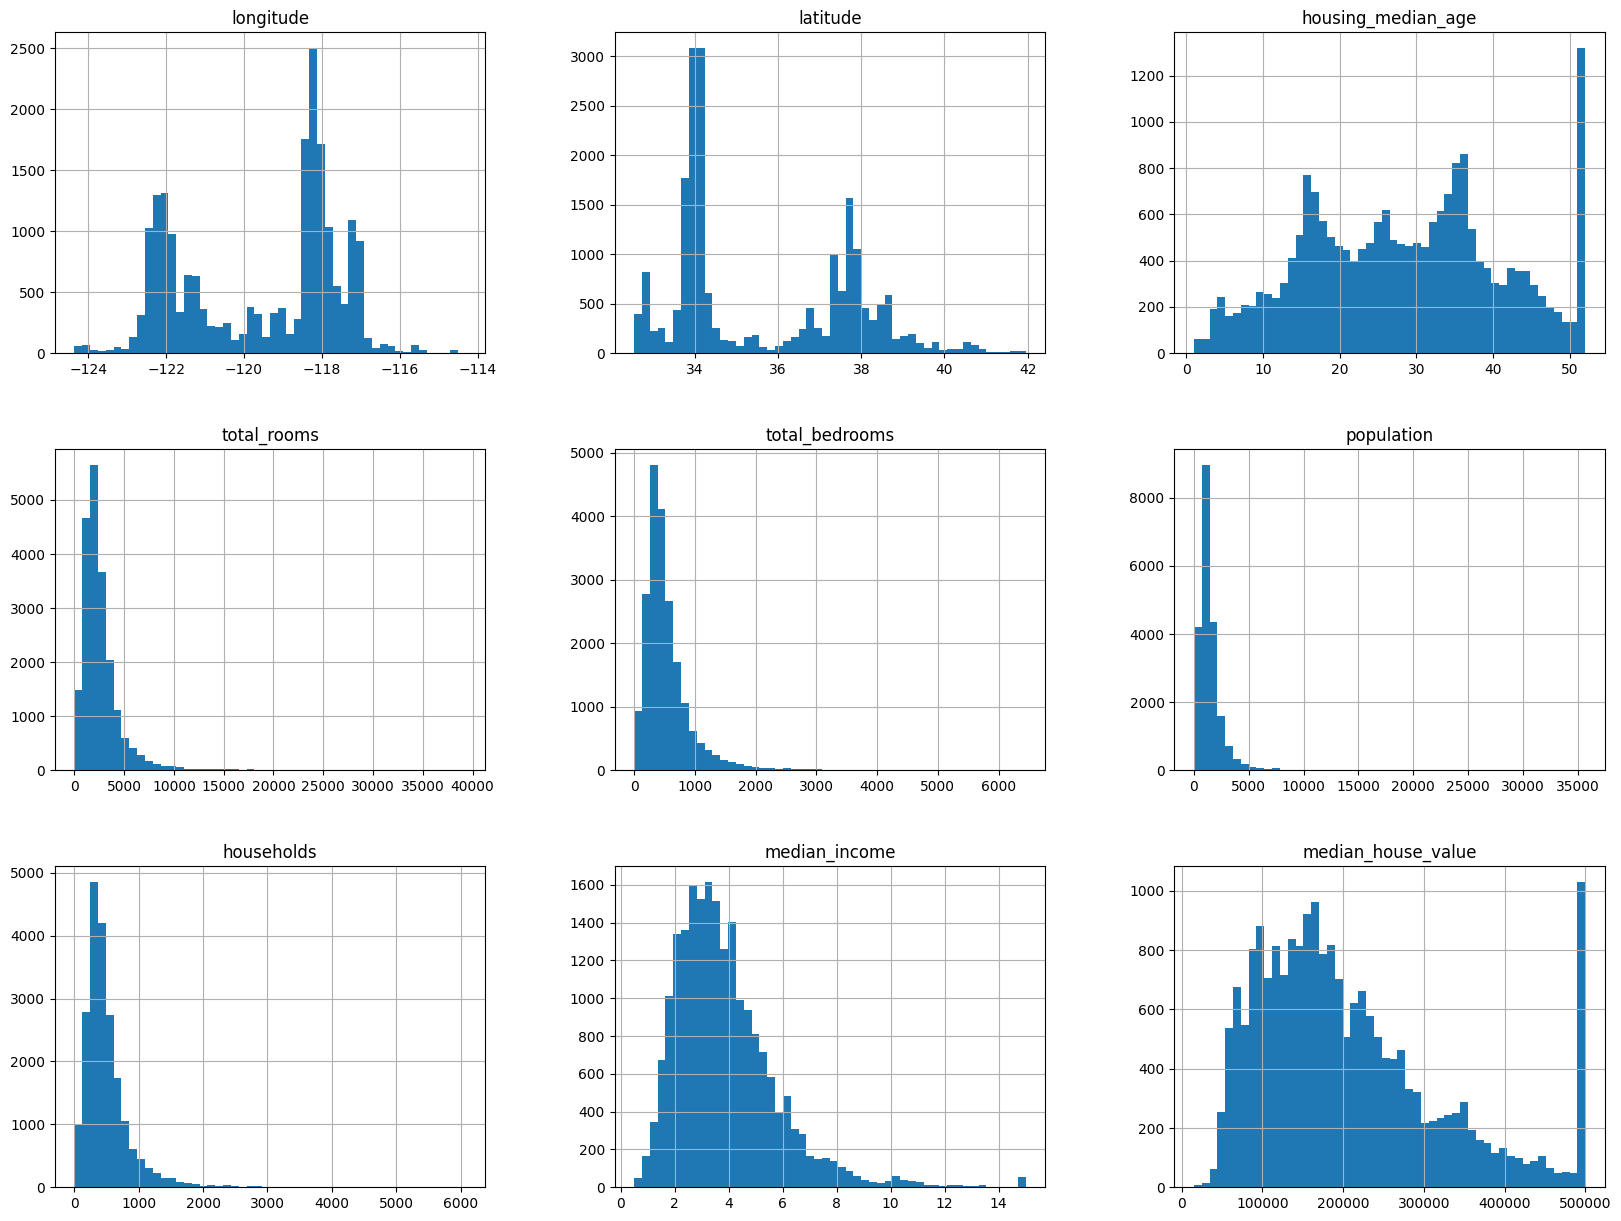

In [33]:
df.hist(bins = 50, figsize=(20, 15))
plt.show()

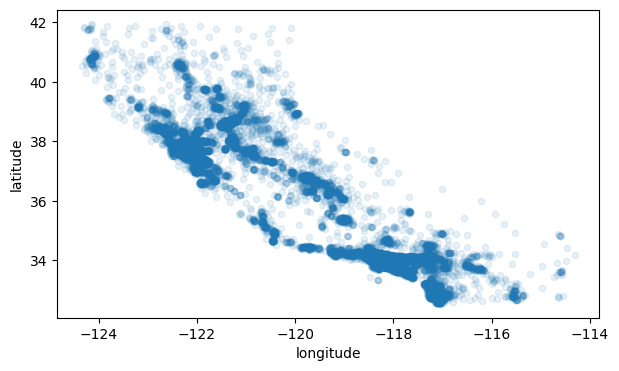

In [34]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.1, figsize=(7,4))
plt.show()

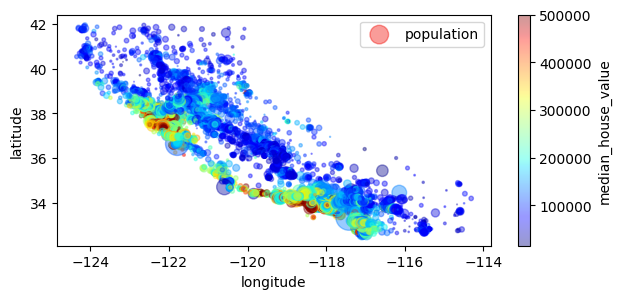

In [35]:
df.plot(colorbar=True, figsize=(7,3), kind="scatter", alpha = 0.4, x = 'longitude', y="latitude",
        label='population', c="median_house_value", cmap=plt.get_cmap("jet"), s=df["population"]/100)

plt.show()

In [36]:
df.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [37]:
# musimy dodać argument numeric_only bo kolumna ocean_proximity jest opisowa, alternatywnie możnaby ją usunąć też po prostu za pomocą df.drop()
df.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False).reset_index().rename(columns={"index":"atrybut", "median_house_value":"wspolczynnik_korelacji"}).to_csv("korelacja.csv", index=False)

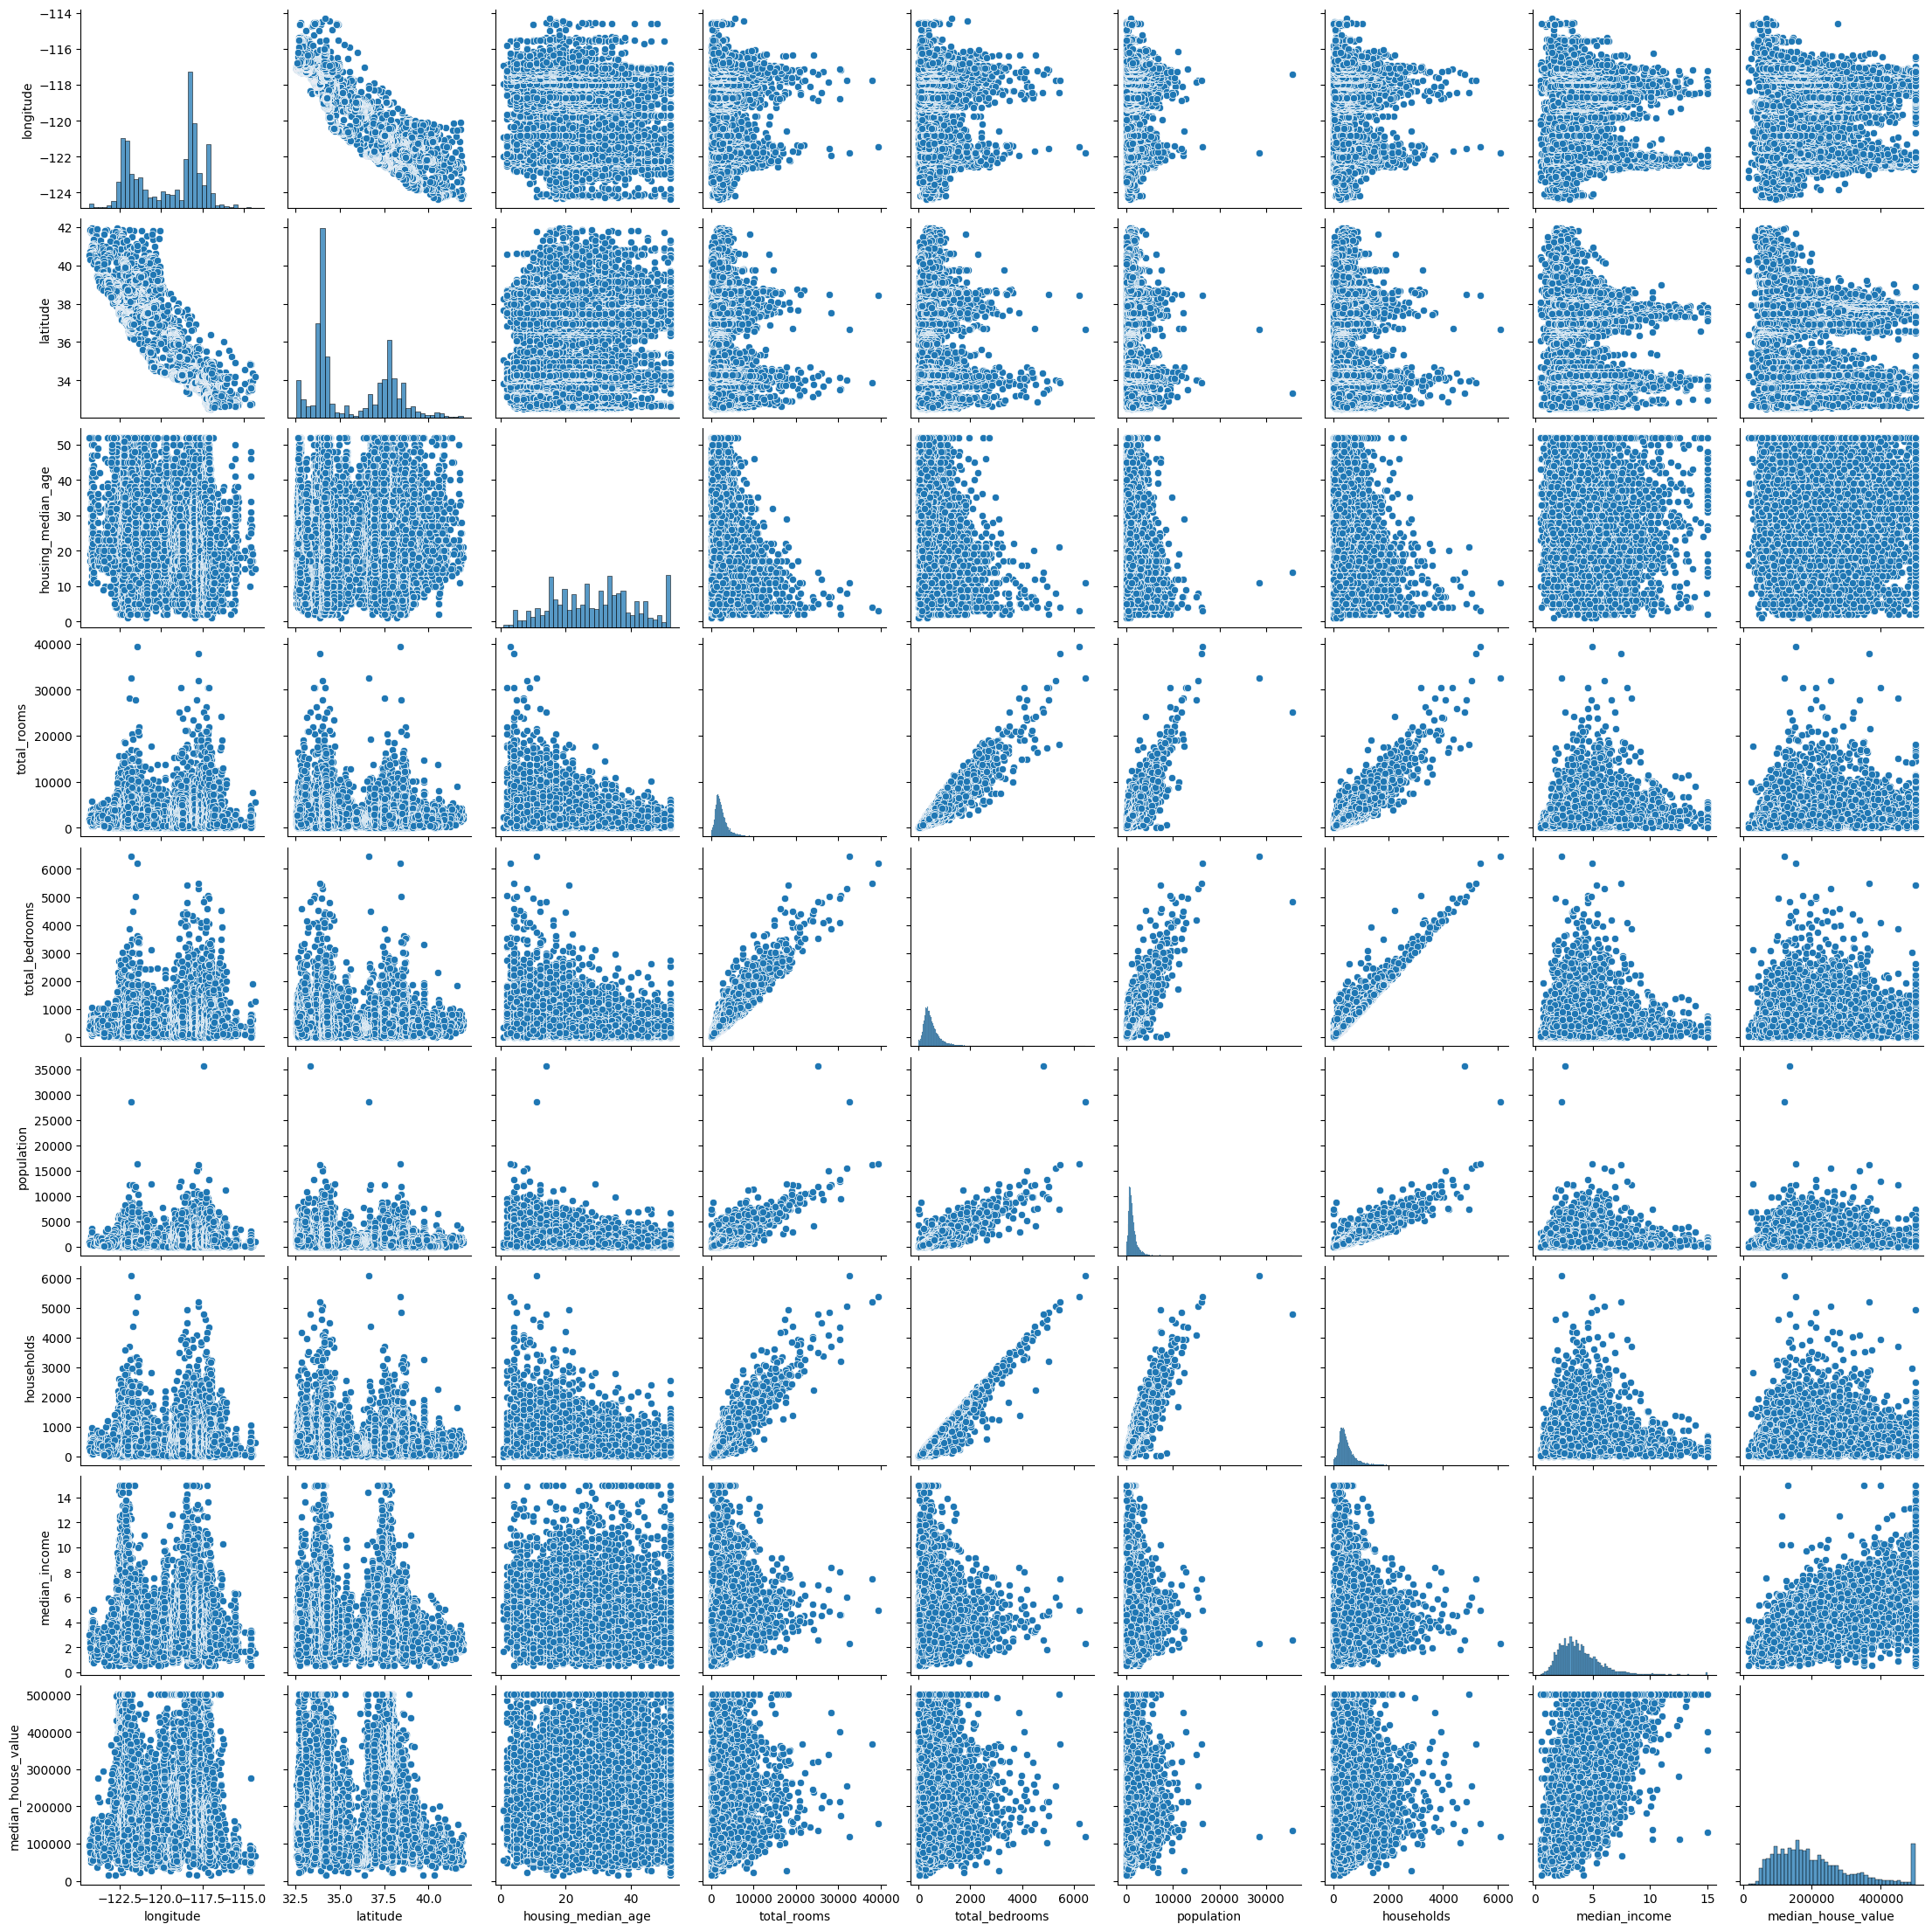

In [38]:
import seaborn as sns

sns.pairplot(df)

In [39]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

len(train_set), len(test_set)

(16512, 4128)

In [40]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [41]:
train_set.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924485,-0.101818,0.038676,0.063064,0.094276,0.049306,-0.017040,-0.046349
latitude,-0.924485,1.000000,0.005296,-0.029224,-0.059998,-0.102499,-0.064061,-0.076571,-0.142983
housing_median_age,-0.101818,0.005296,1.000000,-0.360922,-0.320624,-0.292283,-0.302796,-0.121711,0.103706
total_rooms,0.038676,-0.029224,-0.360922,1.000000,0.930489,0.857936,0.920482,0.198268,0.133989
total_bedrooms,0.063064,-0.059998,-0.320624,0.930489,1.000000,0.878932,0.980255,-0.009141,0.047980
population,0.094276,-0.102499,-0.292283,0.857936,0.878932,1.000000,0.907452,0.004122,-0.026032
households,0.049306,-0.064061,-0.302796,0.920482,0.980255,0.907452,1.000000,0.012776,0.063714
median_income,-0.017040,-0.076571,-0.121711,0.198268,-0.009141,0.004122,0.012776,1.000000,0.690647
median_house_value,-0.046349,-0.142983,0.103706,0.133989,0.047980,-0.026032,0.063714,0.690647,1.000000


---

## Wnioski

Analiza danych mieszkaniowych z Kalifornii ujawnia, że mediana dochodu jest najsilniejszym predyktorem ceny nieruchomości (korelacja ~0.69), podczas gdy położenie geograficzne, szczególnie bliskość oceanu, również odgrywa istotną rolę. Zbiór danych zawiera 20,640 obserwacji z niewielką liczbą braków danych (207 wartości w kolumnie `total_bedrooms`), co czyni go odpowiednim do budowy modeli predykcyjnych po podstawowym preprocessingu. Dane zostały podzielone na zbiór treningowy (16,512 obserwacji) i testowy (4,128 obserwacji), co umożliwia dalsze modelowanie z wykorzystaniem regresji liniowej, drzew decyzyjnych lub metod ensemble.